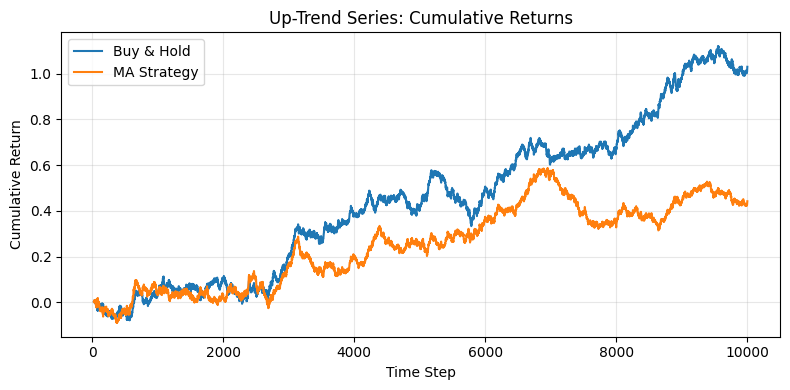

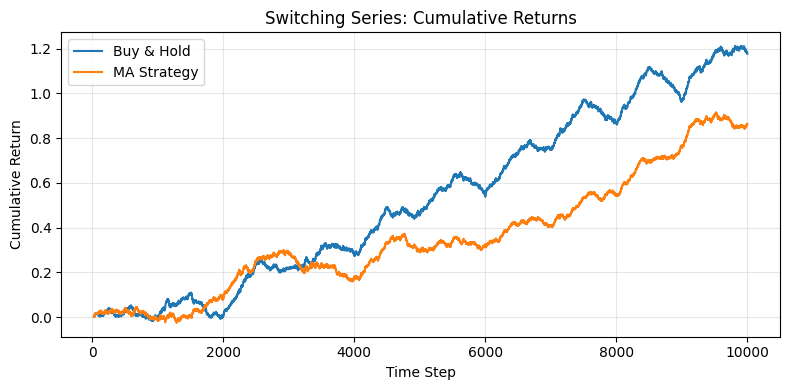

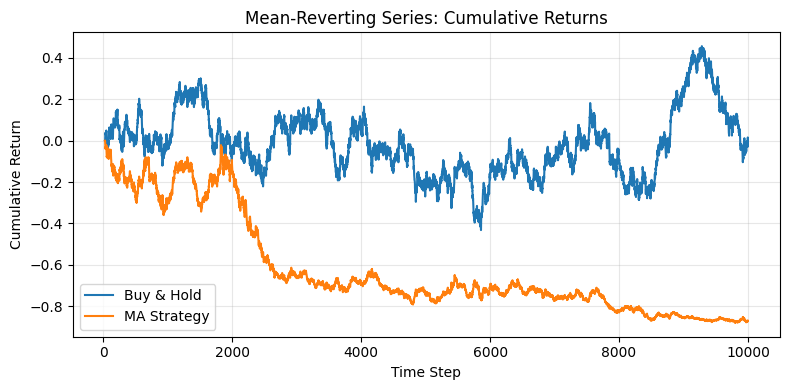

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ─── 1. Simulation Functions ─────────────────────────────────────────────

def simulate_ou_standard(mu: torch.Tensor, theta: float, sigma: float, dt: float) -> torch.Tensor:
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    for t in range(1, T):
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    return P

def simulate_ou_switching(mu: torch.Tensor, theta_pos: float, theta_neg: float,
                          sigma: float, dt: float, switch_interval: int) -> torch.Tensor:
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    for t in range(1, T):
        theta = theta_pos if ((t // switch_interval) % 2) == 0 else theta_neg
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    return P


# ─── 2. Parameters ────────────────────────────────────────────────────────

T             = 10_000
dt            = 1.0 / T
trend_rate    = 0.01
sigma_trend   = 20.0
sigma_flat    = 50.0
sigma_switch  = 10.0
theta_trend   = 2.0
theta_flat    = 20.0
theta_pos     = 7.5
theta_neg     = -2.5
regime_len    = 500
FAST, SLOW    = 10, 27

torch.manual_seed(42)
rng = np.random.default_rng(42)

# ─── 3. Build Mean Series ─────────────────────────────────────────────────

mu_trend  = 50.0 + trend_rate * torch.arange(T, dtype=torch.float)
mu_flat   = torch.full((T,), 50.0)
mu_switch = mu_trend.clone()

# ─── 4. Simulate All Three Paths ───────────────────────────────────────────

P_trend  = simulate_ou_standard(mu_trend, theta_trend,  sigma_trend,  dt)
P_flat   = simulate_ou_standard(mu_flat,  theta_flat,   sigma_flat,   dt)
P_switch = simulate_ou_switching(mu_switch, theta_pos, theta_neg,
                                 sigma_switch, dt, switch_interval=regime_len)

# ─── 5. Backtest Function ─────────────────────────────────────────────────

def backtest_and_plot(P_tensor, name):
    # Convert to NumPy
    P = P_tensor.numpy()
    # compute moving averages
    fast_ma = np.convolve(P, np.ones(FAST)/FAST, mode='valid')
    slow_ma = np.convolve(P, np.ones(SLOW)/SLOW, mode='valid')
    
    # align them so that slow_ma[0] corresponds to P[SLOW-1]
    shift = SLOW - FAST
    signals = np.where(fast_ma[shift:] > slow_ma, 1, -1)
    
    # trim price series to start at index SLOW-1
    P_sub = P[SLOW-1:]
    
    # compute returns
    ret = P_sub[1:] / P_sub[:-1] - 1
    sig = signals[:-1]   # shift signal forward by 1 to avoid lookahead
    
    # cumulative returns
    cum_hold = np.cumprod(1 + ret) - 1
    cum_strat = np.cumprod(1 + ret * sig) - 1
    
    # plot
    x = np.arange(SLOW, T)
    plt.figure(figsize=(8, 4))
    plt.plot(x, cum_hold,  label='Buy & Hold')
    plt.plot(x, cum_strat, label='MA Strategy')
    plt.title(f"{name} Series: Cumulative Returns")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ─── 6. Run and Plot for Each Series ───────────────────────────────────────

backtest_and_plot(P_trend,  "Up-Trend")
backtest_and_plot(P_switch, "Switching")
backtest_and_plot(P_flat,   "Mean-Reverting")
